In [30]:
import numpy as np
import matplotlib.pyplot as plt
from forward_operators import *
import scipy as sc
import mat73

# T H  Original version 2022, updated in 2025

In [55]:
# initialize everything
N = 140
N_det = 280
N_theta = 87 # Arbitrary number of angles
angle_shift = 338 # Arbitrary shift (integer)

# Load measurement data as sinogram
data_name = "stempo_seq8x180_2d_b8.mat"

theta = 2*angle_shift + np.linspace(0, 2*N_theta, N_theta, endpoint=False) # seq8x180 is 2 degree interval
#theta = 8*angle_shift + np.linspace(0, 8*N_theta, N_theta, endpoint=False) # seq8x45 is 8 degree interval
#theta = angle_shift + np.linspace(0, N_theta, N_theta, endpoint=False) # cont360 is 1 degree interval

## TODO: make this into a function, say "load_CTdata_from_mat"
try: # First trie scipy
    data = sc.io.loadmat(f"../../data/{data_name}")
    CtData = data["CtData"][0,0]
    # Load parameters
    param = CtData["parameters"][0,0]
    binningFactor = param["binningPost"][0,0]
    SOD = param["distanceSourceOrigin"][0,0]
    SDD = param["distanceSourceDetector"][0,0]
    ODD = SDD - SOD # Origin-detector-distance
    pixelSize = param["pixelSize"][0,0]*binningFactor
except:
    # Older data is in Matlab -v7.3 format
    data = mat73.loadmat(f"../../data/{data_name}")
    CtData = data["CtData"]
    # Load parameters
    param = CtData["parameters"]
    binningFactor = param["binningPost"]
    SOD = param["distanceSourceOrigin"]
    SDD = param["distanceSourceDetector"]
    ODD = SDD - SOD # Origin-detector-distance
    pixelSize = param["pixelSize"]*binningFactor
m_big = CtData["sinogram"]
m = m_big[angle_shift:angle_shift + N_theta,:] # Take the first N_theta projections from the big sinogram



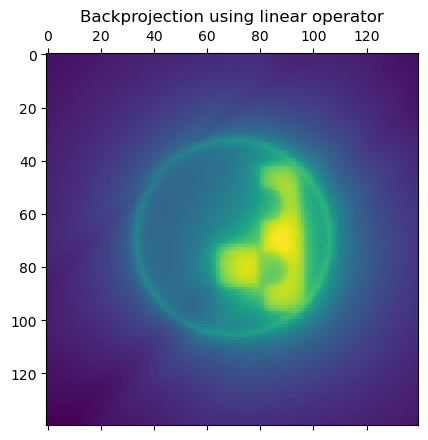

In [56]:
# Create ASTRA forward operator
Aop = createASTRAoperator_fanbeam(N, SOD, ODD, pixelSize, N_det, theta)
BPop = Aop.T*m # Backproject with operator (sinogram can be flattened or matrix)
plt.matshow(BPop.reshape((N,N)))
plt.title('Backprojection using linear operator')
plt.show()

## FBP and Sparse matrix do not currently work!

This is a longstanding issue with ASTRA. I think CUDA implementation should work but that is also misbehaving for me.

In [3]:
# Sanity check with FBP
s = np.ascontiguousarray(m,np.float32) # Needs to be 32 bit and c_contiguous
try:
    fbp = doASTRAfbp_fanbeam(s, N, SOD, ODD, pixelSize, N_det, theta)
    plt.matshow(fbp)
    plt.title("Filtered back-projection")
    plt.show()
except:
    print("ASTRA-related error")

ASTRA-related error


Error: FBP currently only supports parallel projection geometries.


In [ ]:
try:
    # Create ASTRA matrix
    Amat = createASTRAmatrix_fanbeam(N, SOD, ODD, pixelSize, N_det, theta)
    BPmat = Amat.T*m.flatten() # Backproject with matrix (sinogram must be flattened to vector)
    plt.matshow(BPmat.reshape((N,N)))
    plt.title('Backprojection using sparse matrix')
    plt.show()
except:
    print("ASTRA-related error")

ASTRA-related error
